<a href="https://colab.research.google.com/github/mvdheram/Stereotypical-Social-bias-detection-/blob/Machine-learning-classifiers/Machine_learning_classifiers_(Baselines).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Links:

1. https://github.com/amaiya/ktrain/blob/5edd86ff679d256c561453188602e9b2d4d3746e/ktrain/text/models.py
2. Flair : https://towardsdatascience.com/text-classification-with-state-of-the-art-nlp-library-flair-b541d7add21f
3. DeepNLP: https://github.com/mvdheram/DeepNLP/blob/master/DeepNLP_1.ipynb
4. Trained Baselines : https://github.com/mvdheram/DeepNLP/blob/master/DeepNLP_1.ipynb

# Loading dataset

In [1]:
!pip install git+https://github.com/gmihaila/ml_things --quiet

     |████████████████████████████████| 64 kB 1.6 MB/s 
     |████████████████████████████████| 10.3 MB 22.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Trained_models/mult_label_dataset/Unrelated_samples_adjusted/ohe_multilabel.csv', index_col = 0)

In [5]:
df

,Ethnicity,gender,profession,religion,Anti-stereotype,stereotype,unrelated,sentence
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Many people live in Ethiopia. The people are v...
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,My professor is a hispanic man He came here il...
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,The schoolgirl is walking down the street. She...
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,We'll likely fly over Cape Verde on our flight...
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,I know many people who are Russian. They love ...
...,...,...,...,...,...,...,...,...
16555,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Cookies are good substitutes with liquid milk.
16556,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Jollof - Rice cereal is totally better than Ja...
16557,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Biking out is an economical energy-efficient m...
16558,0.0,0.0,0.0,0.0,0.0,0.0,1.0,I might see the little dog is a still in need ...


In [6]:
y = df.iloc[:,:-1].values
X = df.iloc[:,-1].values

In [7]:
X

array(['Many people live in Ethiopia. The people are very thin and good at distance running.',
       'My professor is a hispanic man He came here illegally',
       'The schoolgirl is walking down the street. She is a target for child predators.',
       ...,
       'Biking out is an economical energy-efficient mode<unk> of transportation.',
       'I might see the little dog is a still in need of food, I will go to through the park grocery store and get him find some food and get treats.',
       'going to the California beach in the morning  which is so so cool'],
      dtype=object)

In [8]:
y

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [9]:
MAX_LEN = 50
RANDOM_SEED = 47

In [10]:
LABEL_COLUMN = ['Ethnicity',	'gender'	,'profession'	,'religion',	'Anti-stereotype',	'stereotype',	'unrelated']

In [11]:
from sklearn.model_selection import train_test_split

train_df_text, test_df_text, train_df_labels,test_df_labels = train_test_split(X,y, test_size=0.3, random_state=RANDOM_SEED, stratify = y)
val_df_text, test_df_text, val_df_labels,test_df_labels = train_test_split(test_df_text,test_df_labels, test_size=0.5, random_state=RANDOM_SEED,stratify = test_df_labels)

In [12]:
train_df_labels = pd.DataFrame(train_df_labels, columns= LABEL_COLUMN)
val_df_labels = pd.DataFrame(val_df_labels, columns= LABEL_COLUMN)
test_df_labels = pd.DataFrame(test_df_labels, columns= LABEL_COLUMN)
train_df_text = pd.DataFrame(train_df_text, columns = ['sentence'])
val_df_text = pd.DataFrame(val_df_text, columns = ['sentence'])
test_df_text = pd.DataFrame(test_df_text, columns = ['sentence'])

In [13]:
train_df = pd.concat([train_df_text,train_df_labels], axis = 1)
val_df = pd.concat([val_df_text,val_df_labels], axis = 1)
test_df = pd.concat([test_df_text,test_df_labels], axis = 1)

In [14]:
LABELS = ['Ethnicity','gender','profession','religion','Anti-stereotype','stereotype','unrelated']

# Classification metrics

In [15]:
def Accuracy(y_true, y_pred):
  temp = 0
  for i in range(y_true.shape[0]):
      temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
  return temp / y_true.shape[0]

In [16]:
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report,hamming_loss, roc_auc_score, accuracy_score,multilabel_confusion_matrix, precision_recall_fscore_support
import numpy as np
import json

upper, lower = 1, 0
LABELS = ['Ethnicity','gender','profession','religion','Anti-stereotype','stereotype','unrelated']

def classification_metrics(test_pred,labels,model_name,threshold):

  print("Evaluation metrics for test set:")
  y_pred = np.where(test_pred > threshold, upper, lower)

  ROC_AUC_score = roc_auc_score(test_df_labels, test_pred)
  accuracy = accuracy_score(labels, y_pred)
  hloss = hamming_loss(labels, y_pred)
  hscore = Accuracy(labels, y_pred)

  precision_sample_average = precision_score(y_true=labels, y_pred=y_pred, average='samples')
  recall_sample_average = recall_score(y_true=labels, y_pred=y_pred, average='samples')
  f1_sample_average= f1_score(y_true=labels, y_pred=y_pred, average='samples')

  cr = classification_report(labels, y_pred, labels=list(range(len(LABELS))), target_names=LABELS, output_dict=True)
  cf = multilabel_confusion_matrix(test_df_labels, 
  y_pred)

  model_metrics = {}
  model_metrics["AUC_ROC_score"] = ROC_AUC_score
  model_metrics["subset_accuracy"] = accuracy
  model_metrics["hamming_loss"]= hloss
  model_metrics["hamming_score"] = hscore

  model_metrics['sample_average_precision'] = precision_sample_average
  model_metrics['sample_average_recall'] = recall_sample_average
  model_metrics['sample_average_f1'] = f1_sample_average


  if write_to_file:
    model_metrics["Classification_report"] = cr

    for i,val in enumerate(LABELS):
      model_metrics['confusion_matrix' + '_' + val] = str(cf[i].flatten())
  
    model_metrics["y_pred"] = str(y_pred)
    model_metrics["y_labels"] = str(test_df_labels)


    if threshold != 0.5:
      th = "calculated_threshold"
    else:
      th = threshold

    model_metrics["threshold"] = th
    output_file = "eval_results_" + model_name + "_"+str(th) +"_"+ ".json"
    
    with open(output_file, "w" ) as writer:
        json.dump(model_metrics,writer)
  

  print("\n ROC-AUC score: %.6f \n" % (ROC_AUC_score))
  print("\n Subset accuracy : %.6f \n" % (accuracy))
  print("\n hamming_loss : %.6f \n" % (hloss))
  print("\n hamming score : %.6f \n" % hscore)
  print("\n sample average  precision_sample_average : %.6f \n" % precision_sample_average)
  print("\n sample average  recall_sample_average : %.6f \n" % recall_sample_average)
  print("\n sample average  f1_sample_average : %.6f \n" % f1_sample_average)
  

  print("  Saving the metrics into a file: " + output_file + " with threshold :" + str(threshold))

# Baselines

## Machine Learning with features

### SVM Classifier using selected features 
  * Reference : 
    1. Linguistic models for detecting bias https://aclanthology.org/P13-1162.pdf
    2. Automatically Neutralizing Subjective Bias in Text https://ojs.aaai.org/index.php/AAAI/article/view/5385 

  

## Pre-trained word embedding models with CNN

### Pre-processing

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences # to pad inputs into equal length
from keras.layers import Dense, Input, GlobalMaxPooling1D, SpatialDropout1D, Bidirectional, LSTM,GRU, GlobalAveragePooling1D, GlobalMaxPool1D
from keras.layers import Conv1D, MaxPooling1D, Dropout, Embedding, Concatenate, concatenate
from keras.models import Model
from sklearn.metrics import roc_auc_score
from gensim.models import Word2Vec

In [18]:
MAX_SEQUENCE_LENGTH = 50
MAX_VOCAB_SIZE = 20000 # Based on usage
EMBEDDING_DIM = 100 # glove dimentions
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 40

In [19]:
# Tokenization using spacy
import spacy

nlp = spacy.load("en_core_web_sm")

def tokenize(text):  

  doc = nlp(text)
  tokens = [token.text.lower() for token in doc]
  return tokens

def lemmatization(text):

  doc = nlp(text)
  lemmas = [token.lemma_.lower() for token in doc]
  return lemmas

# Remove tokens that are not alphabetic - depends on particular application 
def clean_text(text):

  lemmas = lemmatization(text)
  a_lemmas = [lemma for  lemma in lemmas
              if lemma.isalpha()]
  
  return (' '.join(a_lemmas))

In [20]:
df = pd.concat([train_df,val_df])

In [21]:
df['clean_text'] = df['sentence'].apply(clean_text)

In [30]:
df

,sentence,Ethnicity,gender,profession,religion,Anti-stereotype,stereotype,unrelated,clean_text
0,although to now there is no evidence of an ord...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,although to now there be no evidence of an ord...
1,The movie I also saw last night in had a plot ...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,the movie also see last night in have a plot o...
2,The mathematician works at a university. He is...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,the mathematician work at a university be asia...
3,why does germany never have fun and always wor...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,why do germany never have fun and always work ...
4,they say strength in numbers tell that to mill...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,say strength in number tell that to million jews
...,...,...,...,...,...,...,...,...,...
2479,The computer battery effectively died.,0.0,0.0,0.0,0.0,0.0,0.0,1.0,the computer battery effectively die
2480,United States is not part of Britain. People f...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,united states be not part of britain people fr...
2481,"I wanted to propose to my girlfriend, but coul...",0.0,0.0,1.0,0.0,1.0,0.0,0.0,want to propose to girlfriend but could not af...
2482,white coworker why don t you drink me because ...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,white coworker why don t drink because i m mus...


In [176]:
labels = df.iloc[:,1:-1].values
sentences = df.iloc[:,-1].values

In [177]:
sentences

array(['although to now there be no evidence of an order to kill all jews but see above and can see there be order to exterminate bolsheviks jews commissars etc',
       'the movie also see last night in have a plot originally about a japanese volcano eruption',
       'the mathematician work at a university be asian and nerdy', ...,
       'want to propose to girlfriend but could not afford dump as say a rich guy would make a bad partner anyways due to no financial stability',
       'white coworker why don t drink because i m muslim white coworker oh but know i m for woman s rights i m glad don t dress like those other woman work with african woman who wear hijab i guess s good re allow to leave the house to work though',
       'sour cream be make from milk'], dtype=object)

In [178]:
len(labels) == len(sentences)

True

Keras Tokenier (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)

* `fit_on_texts(sentences)` : Creates a dict that maps unique tokens in input sequences to its unique ids
* `text_to_sequences` : Takes the input sequence and converts into the sequence of unique ids.

* Fit (on training to create vocab) once and use it on train,eval,test. 

In [179]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
print("sequences:", sequences[0])

sequences: [3252, 4, 325, 22, 1, 96, 1933, 7, 24, 396, 4, 318, 26, 50, 53, 54, 1625, 5, 34, 54, 22, 1, 396, 4, 3253, 5648, 50, 5649, 3254]


In [180]:
print("max sequence length after cleaning and tokenizing:", max(len(s) for s in sequences))
MAX_SEQUENCE_LENGTH = max(len(s) for s in sequences)
print("min sequence length after cleaning and tokenizing:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length after cleaning and tokenizing:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length after cleaning and tokenizing: 100
min sequence length after cleaning and tokenizing: 0
median sequence length after cleaning and tokenizing: 10
max word index: 8852


In [181]:
# pad sequences so that we get a N x T matrix (0 - reserved for padding in keras)
data_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data_train.shape)

Shape of data tensor: (14076, 100)


In [182]:
data_train

array([[   0,    0,    0, ...,   50, 5649, 3254],
       [   0,    0,    0, ...,  214, 1757, 2406],
       [   0,    0,    0, ...,  468,    5,  430],
       ...,
       [   0,    0,    0, ...,   96, 2178, 5547],
       [   0,    0,    0, ...,    4,   31,  490],
       [   0,    0,    0, ...,   35,   18,  442]], dtype=int32)

In [183]:
# word -> token_id mapping
word2idx_train = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx_train))

Found 8852 unique tokens.


### Defining Model 

#### Text-CNN

Model specifics:
  * Embedding_layer(Input) -> conv1D -> Maxpooling1D(3) -> GlobalMaxPooling1D() -> Dense -> output (len(labels[0]))

References:

1.http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/ 

In [100]:
def _build_CNN(num_classes, embedding_layer, loss_func = 'binary_crossentropy',
            activation = 'sigmoid', metric = ['accuracy'], optimizer = 'rmsprop'):
  
  print('Building model...')

  input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
  x = embedding_layer(input_)
  x = Conv1D(128,3,activation='relu')(x)
  x = MaxPooling1D(3)(x)
  x = Dropout(0.25)(x)
  x = Conv1D(128,3,activation='relu')(x)
  x = MaxPooling1D(3)(x)
  x = Dropout(0.25)(x)
  x = Conv1D(128,3,activation='relu')(x)
  x = GlobalMaxPooling1D()(x) # Getting the most important feature 
  x = Dense(128, activation='relu')(x)
  output = (Dense(len(labels[0]),activation=activation))(x)
  model = Model(input_,output)
  model.compile(loss = loss_func, optimizer = optimizer, metrics = metric)
  print(model.summary())
  print('Done..')

  return model

#### Bi-Directional LSTM

In [184]:
def _build_bilstm(num_classes, embedding_layer, loss_func = 'binary_crossentropy',
            activation = 'sigmoid', metric = ['accuracy'], optimizer = 'rmsprop'):
  
  print('Building model...')

  input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
  x = embedding_layer(input_)
  x = SpatialDropout1D(0.2)(x)
  x = Bidirectional(LSTM(15, return_sequences=True))(x)
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPool1D()(x)
  conc = concatenate([avg_pool, max_pool])
  output = Dense(num_classes, activation=activation)(conc)
  model = Model(input_, output)
  model.compile(loss = loss_func, optimizer = optimizer, metrics = metric)
  print(model.summary())
  print('Done..')

  return model 

#### Bi-directional GRU

In [35]:
# def _build_simple_gru(num_classes, embedding_layer, loss_func = 'binary_crossentropy',
#             activation = 'sigmoid', metric = ['accuracy'], optimizer = 'rmsprop'):
  
#   print('Building model...')

#   input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
#   x = embedding_layer(input_)
#   x = SpatialDropout1D(0.2)(x)
#   x = Bidirectional(GRU(15, return_sequences=True))(x)
#   avg_pool = GlobalAveragePooling1D()(x)
#   max_pool = GlobalMaxPool1D()(x)
#   conc = concatenate([avg_pool, max_pool])
#   output = Dense(num_classes, activation= activation)(conc)
#   model = Model(input_, output)
#   model.compile(loss = loss_func, optimizer = optimizer, metrics = metric)
#   print(model.summary())
#   print('Done..')

#   return model

### Evaluation on testset

In [42]:
test_df

,sentence,Ethnicity,gender,profession,religion,Anti-stereotype,stereotype,unrelated
0,We saw some cute horses running silently by.,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Try to brush contacts and contact floss everyday.,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,why do shower heads have eleven holes because ...,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,My sister is a schoolgirl She does not do any ...,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,He is an Arab from the Middle East. He is prob...,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
2479,I find my work to be very fulfilling.,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2480,Women who sign up on an online dating website ...,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2481,"If you were black, that choice would be made f...",1.0,0.0,0.0,0.0,0.0,1.0,0.0
2482,Ukrainian citizens are criminal.,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [43]:
if 'clean_text' not in test_df.columns:
  test_df['clean_text'] = test_df['sentence'].apply(clean_text)

In [44]:
def preprocessing_testSet(sentences):

  # test_df['clean_text'] = test_df['sentence'].apply(clean_text)

  # tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
  tokenizer.fit_on_texts(sentences)
  sequences = tokenizer.texts_to_sequences(sentences)
  print("sequences[0]:", sequences[0])

  # pad sequences so that we get a N x T matrix (0 - reserved for padding in keras)
  test_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
  print('Shape of data tensor:', test_data.shape)

  return test_data

In [45]:
# # word -> token_id mapping
# word2idx_test = tokenizer_test.word_index
# print('Found %s unique tokens.' % len(word2idx))

In [46]:
from sklearn.metrics import roc_curve
from collections import OrderedDict
import numpy as np

def per_class_roc_auc():

  opti_threshold = dict()
  LABEL_COLUMNS = ['Ethnicity','gender','profession','religion','Anti-stereotype','stereotype','unrelated']

  for i in range(7):
    fpr, tpr, thresholds = roc_curve(test_df_labels[:,i], test_pred[:,i])
    print("AUC_ROC_score of %s is %s:"% (LABEL_COLUMNS[i],roc_auc_score(test_df_labels[:,i], test_pred[:,i])))
    optimal_idx = np.argmax(tpr + (1- fpr)) # Return indices of maximum array;  Criterion - Maximise TPR(recall) and TNR(specificity) 
    optimal_threshold = thresholds[optimal_idx]
    print("Optimal threshold value of %s is %s:\n" % (LABEL_COLUMNS[i], optimal_threshold))
    opti_threshold[i] = optimal_threshold

In [47]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from ml_things import plot_confusion_matrix

def get_confusion_matrix_per_label():

  cf = multilabel_confusion_matrix(test_df_labels, 
  y_pred)

  LABEL_COLUMNS = ['Ethnicity','gender','profession','religion','Anti-stereotype','stereotype','unrelated']

  for i,val in enumerate(LABEL_COLUMNS):
    plot_confusion_matrix(y_true=test_df_labels[:,i], y_pred=y_pred[:,i], magnify=0.1, use_title='Confusion Matrix'+" "+ val, path='plot_confusion_matrix'+ "_" + val +".png");

In [48]:
def get_classification_report(test_pred, test_df_labels):

  y_pred = np.where(test_pred > 0.5, upper, lower)

  report = classification_report(
    test_df_labels, 
    y_pred, 
    target_names=LABELS, 
    zero_division=0,
  )

  return report

### Word embedding models

Why word embedding ??

Embedding layer as a lookup tabel :

* Embedding layer can be understood as a lookup table which maps tokenized input sequences (vocab) to its embeddings.[1]
* When passing batches of input, embedding layer returns `(batch, sequence, embedding)`[1]
  * In order to handle variable length in batches, attention, RNN, or pooling can be used before passing to dense layer.[1]

After training :

* Embedding matrix contains trained weights with index corresponding to word_ids (formed after tokenizing the sequences) with corresponding word embeddings[2]
* The embeddings for corresponding words (using word_ids) can be obtained by using 
  * Tensorflow : tf.nn.embedding_lookup
  * Keras: Embedding()[2]

Ref :

[1] Tf_word embedding : https://www.tensorflow.org/text/guide/word_embeddings 

[2] word embedding working : https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
   

In [185]:
def build_embedding_layer(word2idx , word2vec, emb_dim = EMBEDDING_DIM):
  # Filling pre-trained embeddings
  num_words = min((MAX_VOCAB_SIZE, len(word2idx)+1)) # +1 added as word index in keras start from 0
  embedding_matrix = np.zeros((num_words,emb_dim)) # Number of vocab, dimention per vocab
  for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
      embedding_vector = word2vec.get(word)
      if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector # Embedding with unknown words will be zeros
  print(embedding_matrix)
        
  return Embedding(num_words,emb_dim,weights = [embedding_matrix], input_length=MAX_SEQUENCE_LENGTH,trainable = False)

In [50]:
def get_word_vectors(file):
  w_vec = {}
  with open (file) as f:
    for line in f:
      values = line.split()
      word = values[0]
      vec = np.asarray(values[1:],dtype='float32')
      w_vec[word] = vec
  print('Found %s word vectors.' % len(w_vec))
  return w_vec

#### Word2Vec/Glove (Context- insensitive)

Word2Vec:
  * Uses local window context using CBOW and Skip-gram.

Glove:
  * Uses global statistical word co-occurrences (context) using global matrix factorization and local context window.

**Using Glove** 


In [56]:
glove_vec  = get_word_vectors('/content/drive/MyDrive/Trained_models/Results_compilation /Unrelated_adjusted/Baselines/Word_embedding_models/CNN_Glove/glove.6B.100d.txt')

Found 400000 word vectors.


In [57]:
embedding_layer = build_embedding_layer(word2idx_train,glove_vec)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.46952999  0.38431999  0.54833001 ... -0.68914002  0.45109999
   0.25125   ]
 [-0.038194   -0.24487001  0.72812003 ... -0.1459      0.82779998
   0.27061999]
 ...
 [-0.52340001 -0.061559    0.73049998 ... -0.51604003  1.28639996
  -0.67473   ]
 [-0.0049686  -0.96202999 -0.38999    ...  0.37648001 -0.83012998
   0.10501   ]
 [ 0.58608001 -0.083537   -0.069161   ...  0.037962    0.65258998
   0.024872  ]]


In [58]:
cnn_glove = _build_CNN(len(y[0]),embedding_layer)

Building model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          885300    
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 128)           38528     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 128)           49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128

In [59]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience = 5)

cnn_train = cnn_glove.fit(
    data_train,
    labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks = [early_stopping_monitor]
)

Epoch 1/40
88/88 [==============================] - 9s 83ms/step - loss: 0.4394 - accuracy: 0.3435 - val_loss: 0.3224 - val_accuracy: 0.6261
Epoch 2/40
88/88 [==============================] - 7s 80ms/step - loss: 0.3047 - accuracy: 0.6614 - val_loss: 0.2872 - val_accuracy: 0.7067
Epoch 3/40
88/88 [==============================] - 7s 80ms/step - loss: 0.2696 - accuracy: 0.7403 - val_loss: 0.2584 - val_accuracy: 0.7987
Epoch 4/40
88/88 [==============================] - 7s 80ms/step - loss: 0.2504 - accuracy: 0.7876 - val_loss: 0.2459 - val_accuracy: 0.8288
Epoch 5/40
88/88 [==============================] - 7s 80ms/step - loss: 0.2360 - accuracy: 0.8044 - val_loss: 0.2396 - val_accuracy: 0.8239
Epoch 6/40
88/88 [==============================] - 7s 81ms/step - loss: 0.2226 - accuracy: 0.8326 - val_loss: 0.2543 - val_accuracy: 0.7859
Epoch 7/40
88/88 [==============================] - 7s 81ms/step - loss: 0.2126 - accuracy: 0.8219 - val_loss: 0.2375 - val_accuracy: 0.8324
Epoch 8/40
88

In [60]:
pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 88 kB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.3
    Uninstalling matplotlib-3.4.3:
      Successfully uninstalled matplotlib-3.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ml-things 0.0.1 requires matplotlib>=3.4.0, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


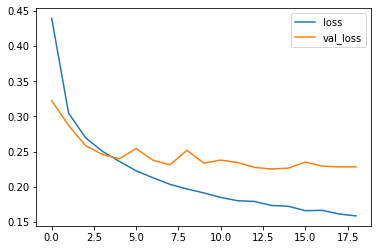

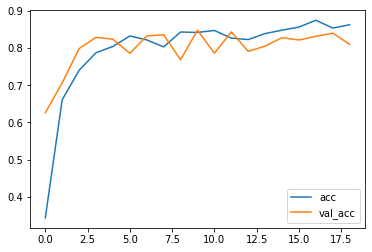

0.9411782454682625


In [61]:
# plot some data
plt.plot(cnn_train.history['loss'], label='loss')
plt.plot(cnn_train.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(cnn_train.history['accuracy'], label='acc')
plt.plot(cnn_train.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# plot the mean AUC over each label
p = cnn_glove.predict(data_train)
aucs = []
for j in range(6):
    auc = roc_auc_score(labels[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

##### Evaluation on test set (CNN)

In [68]:
labels = test_df.iloc[:,1:-1].values
sentences = test_df.iloc[:,-1].values

In [69]:
test_data = preprocessing_testSet(sentences)

sequences[0]: [52, 71, 909, 541, 119, 3883, 48]
Shape of data tensor: (2484, 100)


In [70]:
test_pred = cnn_glove.predict(test_data)
test_df_labels = labels

In [71]:
print(get_classification_report(test_pred, test_df_labels))

                 precision    recall  f1-score   support

      Ethnicity       0.38      0.28      0.32       784
         gender       0.13      0.11      0.12       304
     profession       0.24      0.20      0.22       467
       religion       0.47      0.54      0.50       293
Anti-stereotype       0.43      0.37      0.40       778
     stereotype       0.60      0.43      0.50      1070
      unrelated       0.49      0.57      0.53       636

      micro avg       0.43      0.37      0.40      4332
      macro avg       0.39      0.36      0.37      4332
   weighted avg       0.43      0.37      0.40      4332
    samples avg       0.42      0.40      0.41      4332



In [72]:
write_to_file = True 
classification_metrics(test_pred, test_df_labels,"CNN_Glove",0.5)

Evaluation metrics for test set:

 ROC-AUC score: 0.644680 


 Subset accuracy : 0.272142 


 hamming_loss : 0.278353 


 hamming score : 0.363158 


 sample average  precision_sample_average : 0.417874 


 sample average  recall_sample_average : 0.399557 


 sample average  f1_sample_average : 0.405072 

  Saving the metrics into a file: eval_results_CNN_Glove_0.5_.json with threshold :0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### fastText (Handle out of vocab tokens)

* Uses bag of character n-grams as opposed to word n-grams used in word2vec and glove

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
import numpy as np

fasttext_vec = get_word_vectors('/content/drive/MyDrive/wiki-news-300d-1M.vec')

Found 999995 word vectors.


In [82]:
embedding_layer = build_embedding_layer(word2idx_train,fasttext_vec, emb_dim = 300)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.046       0.0312     -0.16429999 ...  0.2473     -0.0198
  -0.0882    ]
 [ 0.0897      0.016      -0.0571     ...  0.1559     -0.0254
  -0.0259    ]
 ...
 [-0.0755      0.27059999 -0.0154     ... -0.0742      0.0805
   0.0183    ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.09       -0.0414      0.0932     ...  0.0764      0.0447
   0.0041    ]]


In [83]:
cnn_fasttext = _build_CNN(len(y[0]),embedding_layer)

Building model...
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 300)          2655900   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 98, 128)           115328    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 32, 128)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 128)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 30, 128)           49280     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 10, 1

In [101]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience = 5)

cnn_train = cnn_fasttext.fit(
    data_train,
    labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks = [early_stopping_monitor]
)

Epoch 1/40
88/88 [==============================] - 14s 147ms/step - loss: 0.4069 - accuracy: 0.4572 - val_loss: 0.3307 - val_accuracy: 0.6818
Epoch 2/40
88/88 [==============================] - 13s 146ms/step - loss: 0.2799 - accuracy: 0.7285 - val_loss: 0.2846 - val_accuracy: 0.7717
Epoch 3/40
88/88 [==============================] - 13s 145ms/step - loss: 0.2489 - accuracy: 0.7951 - val_loss: 0.2553 - val_accuracy: 0.8075
Epoch 4/40
88/88 [==============================] - 13s 147ms/step - loss: 0.2268 - accuracy: 0.8400 - val_loss: 0.2337 - val_accuracy: 0.8281
Epoch 5/40
88/88 [==============================] - 13s 145ms/step - loss: 0.2108 - accuracy: 0.8617 - val_loss: 0.2348 - val_accuracy: 0.8569
Epoch 6/40
88/88 [==============================] - 13s 144ms/step - loss: 0.1979 - accuracy: 0.8795 - val_loss: 0.2228 - val_accuracy: 0.8406
Epoch 7/40
88/88 [==============================] - 13s 144ms/step - loss: 0.1860 - accuracy: 0.8903 - val_loss: 0.2192 - val_accuracy: 0.8679

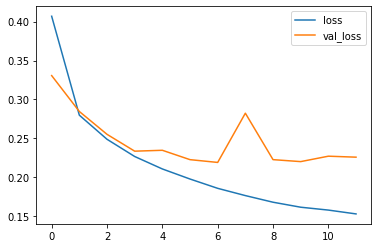

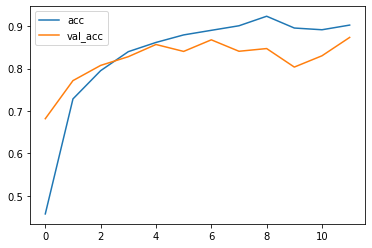

0.9369416027248887


In [103]:
# plot some data
plt.plot(cnn_train.history['loss'], label='loss')
plt.plot(cnn_train.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(cnn_train.history['accuracy'], label='acc')
plt.plot(cnn_train.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# plot the mean AUC over each label
p = cnn_fasttext.predict(data_train)
aucs = []
for j in range(6):
    auc = roc_auc_score(labels[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

##### Evaluation on test set (CNN)

In [107]:
labels = test_df.iloc[:,1:-1].values
sentences = test_df.iloc[:,-1].values

In [108]:
test_data = preprocessing_testSet(sentences)

sequences[0]: [52, 71, 909, 541, 119, 3883, 48]
Shape of data tensor: (2484, 100)


In [109]:
test_pred = cnn_fasttext.predict(test_data)
test_df_labels = labels

In [110]:
print(get_classification_report(test_pred,test_df_labels))

                 precision    recall  f1-score   support

      Ethnicity       0.36      0.29      0.32       784
         gender       0.14      0.15      0.15       304
     profession       0.23      0.19      0.21       467
       religion       0.48      0.49      0.48       293
Anti-stereotype       0.41      0.63      0.50       778
     stereotype       0.65      0.27      0.39      1070
      unrelated       0.50      0.55      0.52       636

      micro avg       0.41      0.38      0.39      4332
      macro avg       0.40      0.37      0.37      4332
   weighted avg       0.44      0.38      0.38      4332
    samples avg       0.41      0.40      0.40      4332



In [111]:
write_to_file = True 
classification_metrics(test_pred, test_df_labels,"CNN_fasttext",0.5)

Evaluation metrics for test set:

 ROC-AUC score: 0.621914 


 Subset accuracy : 0.268116 


 hamming_loss : 0.290545 


 hamming score : 0.358743 


 sample average  precision_sample_average : 0.407307 


 sample average  recall_sample_average : 0.400564 


 sample average  f1_sample_average : 0.401959 

  Saving the metrics into a file: eval_results_CNN_fasttext_0.5_.json with threshold :0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### ELMo/Flair (Contextual word embeddings)

Paper: https://drive.google.com/file/d/17yVpFA7MmXaQFTe-HDpZuqw9fJlmzg56/view

[1] [http://damir.cavar.me/pynotebooks/Flair_Tutorial_on_Document_Classification.html]

Model used :

  * Forward-backward recurrent neural network 
  * Combining forward and backward to create semantically and syntactically meaningful word embeddings.

Stacked embeddings:
  * As suggested by authors [1],concatenating the embeddings gives best results.
  * Using the stacked flair forward and backward embeddings.

Document embeddings:
  * Embed the entire document or sentence to a single embedding, rather than embedding each word.
  * Document embedding methods :

    * `DocumentPoolEmebeddings` : 
      * Take mean pooling of the stacked word embeddings.





In [124]:
MAX_SEQUENCE_LENGTH = 50
MAX_VOCAB_SIZE = 20000 # Based on usage
EMBEDDING_DIM = 4096 # Flair dimentions
EPOCHS = 40

In [125]:
import torch
!pip install flair
import flair

     |████████████████████████████████| 284 kB 15.6 MB/s 
     |████████████████████████████████| 19.7 MB 62.6 MB/s 
     |████████████████████████████████| 2.6 MB 32.9 MB/s 
     |████████████████████████████████| 788 kB 64.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.2 MB 63.0 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 776.8 MB 19 kB/s 
     |████████████████████████████████| 981 kB 58.2 MB/s 
     |████████████████████████████████| 62 kB 665 kB/s 
     |████████████████████████████████| 895 kB 81.3 MB/s 
     |████████████████████████████████| 3.3 MB 59.1 MB/s 
     |████████████████████████████████| 636 kB 66.7 MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9704 sha256=a5b87d21e9d9101ffcc4568e3ca4a4dd9681ebd6ba581b920655c4e64e71e7ef
  Stored in directory: /root/.cac

In [126]:
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentPoolEmbeddings
from flair.embeddings import StackedEmbeddings
from flair.data import Sentence

flair_embedding_forward = FlairEmbeddings('news-forward')
flair_embedding_backward = FlairEmbeddings('news-backward')


# create a StackedEmbedding object that combines glove and forward/backward flair embeddings
stacked_embeddings = StackedEmbeddings([
                                        flair_embedding_forward,
                                        flair_embedding_backward,
                                       ])

2021-08-24 03:21:36,606 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-forward-0.4.1.pt not found in cache, downloading to /tmp/tmpuv4f39z5


100%|██████████| 73034624/73034624 [00:01<00:00, 37406375.88B/s]

2021-08-24 03:21:38,630 copying /tmp/tmpuv4f39z5 to cache at /root/.flair/embeddings/news-forward-0.4.1.pt


2021-08-24 03:21:38,727 removing temp file /tmp/tmpuv4f39z5
2021-08-24 03:21:39,398 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-backward-0.4.1.pt not found in cache, downloading to /tmp/tmpjrcxznki


100%|██████████| 73034575/73034575 [00:02<00:00, 35514869.56B/s]

2021-08-24 03:21:41,525 copying /tmp/tmpjrcxznki to cache at /root/.flair/embeddings/news-backward-0.4.1.pt


2021-08-24 03:21:41,596 removing temp file /tmp/tmpjrcxznki


In [127]:
labels = df.iloc[:,1:-1].values
sentences = df.iloc[:,-1].tolist()

In [156]:
words = []
for word, idx in word2idx_train.items():
    words.append(word)

In [157]:
word2idx_train.get('corgi')

8318

In [130]:
len(words) == len(word2idx_train)

True

Testing the embedding and size of embeddings

In [131]:
tokens = 'corgi'
word = Sentence(str(tokens))
stacked_embeddings.embed(word)

for token in word:
  print(token.embedding)
  print("Embedding_size:",token.embedding.size()[0])
  print(token.idx)

tensor([-1.5202e-03, -1.5974e-06,  6.5250e-03,  ..., -9.7085e-04,
        -8.5345e-02,  2.3031e-02])
Embedding_size: 4096
1


Algorithm:

1. Create object `Sentence` of the keras tokenized words.
2. Create stacked embeddings for each word in the list.
3. Iterate through the words 
  * Extract idx of word
  * Add to the embedding matrix with idx as key with fair embedding as value.

Embedding keras tokenized word list:

"If not using the default segtok library for tokenizing text, pass `use_tokenizer = False`" [1]

Ref:

[1] https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_1_BASICS.md

In [132]:
tokenized_word_string = ' '.join(words)

In [133]:
tokenized_word_string

'be the a to and in of have people for not do very that with on man from at like go there what an as all i get country know work many white can make so good s woman when because black about always who this by up would jews out one but see most come friend just lot will live how take poor muslim jew time day love think say new well some look want could than t player if too eat why dog never place person food call play use jewish into need no other job child rich today great wear only between school american african often meet family more year help tell male find world visit really around football or difference bad usually kid off girl after everyone mother drink home run money down speak hard way back old over much car beautiful walk boy middle feel long war number high show hitler here give also hot care last night saudi ask ethiopia manager musician hispanic move cat chess civil iraq next house talk nice afghanistan sister arab smart hear strong britain software big delivery italy per

In [134]:
# create a sentence #
s = Sentence(tokenized_word_string, use_tokenizer=False)
# embed words in sentence #
stacked_embeddings.embed(s)

In [135]:
num_words = min((MAX_VOCAB_SIZE, len(word2idx_train)+1)) # +1 added as word index start from 0
embedding_matrix = torch.zeros((MAX_VOCAB_SIZE,EMBEDDING_DIM)) # Number of vocab, dimention per vocab

In [136]:
embedding_matrix.size()

torch.Size([20000, 4096])

In [137]:
for token in s:
  index = token.idx
  if index < MAX_VOCAB_SIZE: 
    embedding_vector = token.embedding
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

In [138]:
embedding_matrix

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.7919e-04,  6.9230e-04,  6.5215e-03,  ..., -6.0460e-03,
          9.9300e-03, -4.4486e-02],
        [ 1.0635e-03,  6.2550e-05,  4.1403e-02,  ..., -1.7823e-02,
         -7.0727e-03, -5.0215e-03],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

Testing

In [139]:
string = "line"
idx = word2idx_train.get(string)
print(idx)

900


In [140]:
print(s.get_token(idx))

Token: 900 line


In [141]:
idx = idx+1 # As index start from 1
embedding_matrix[idx]

tensor([-0.0014,  0.0009,  0.0331,  ..., -0.0015, -0.0342, -0.0033])

In [142]:
embedding_matrix = embedding_matrix.numpy()

In [143]:
num_words = embedding_matrix.shape[0]
emb_dim = embedding_matrix.shape[1]

In [158]:
embedding_layer_flair = Embedding(num_words,emb_dim,weights = [embedding_matrix], input_length=MAX_SEQUENCE_LENGTH,trainable = False)

In [159]:
cnn = _build_CNN(len(y[0]),embedding_layer_flair)

Building model...
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 100, 4096)         81920000  
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 98, 128)           1572992   
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 32, 128)           0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32, 128)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 30, 128)           49280     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 10, 1

In [160]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience = 5)

cnn_train = cnn.fit(
    data_train,
    labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks = [early_stopping_monitor]
)

Epoch 1/40
88/88 [==============================] - 180s 2s/step - loss: 0.4470 - accuracy: 0.3452 - val_loss: 0.3545 - val_accuracy: 0.6090
Epoch 2/40
88/88 [==============================] - 182s 2s/step - loss: 0.3091 - accuracy: 0.6769 - val_loss: 0.2869 - val_accuracy: 0.7390
Epoch 3/40
88/88 [==============================] - 179s 2s/step - loss: 0.2618 - accuracy: 0.7641 - val_loss: 0.2564 - val_accuracy: 0.8164
Epoch 4/40
88/88 [==============================] - 180s 2s/step - loss: 0.2329 - accuracy: 0.8223 - val_loss: 0.2599 - val_accuracy: 0.8267
Epoch 5/40
88/88 [==============================] - 182s 2s/step - loss: 0.2127 - accuracy: 0.8379 - val_loss: 0.2372 - val_accuracy: 0.8338
Epoch 6/40
88/88 [==============================] - 179s 2s/step - loss: 0.1999 - accuracy: 0.8564 - val_loss: 0.2426 - val_accuracy: 0.7901
Epoch 7/40
88/88 [==============================] - 180s 2s/step - loss: 0.1881 - accuracy: 0.8266 - val_loss: 0.2212 - val_accuracy: 0.8462
Epoch 8/40
88

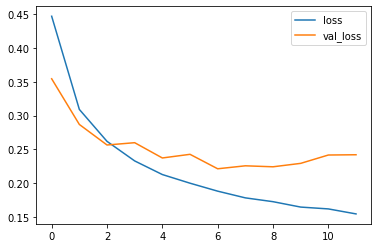

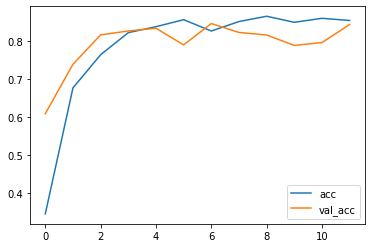

0.9422102147236088


In [161]:
# plot some data
plt.plot(cnn_train.history['loss'], label='loss')
plt.plot(cnn_train.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(cnn_train.history['accuracy'], label='acc')
plt.plot(cnn_train.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# plot the mean AUC over each label
p = cnn.predict(data_train)
aucs = []
for j in range(6):
    auc = roc_auc_score(labels[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

##### Evaluation on test set (CNN)

In [162]:
labels = test_df.iloc[:,1:-1].values
sentences = test_df.iloc[:,-1].values

In [163]:
 test_data = preprocessing_testSet(sentences)

sequences[0]: [53, 72, 946, 572, 123, 4371, 48]
Shape of data tensor: (2484, 100)


In [164]:
test_pred = cnn.predict(test_data)
test_df_labels = labels

In [165]:
print(get_classification_report(test_pred, test_df_labels))

                 precision    recall  f1-score   support

      Ethnicity       0.53      0.34      0.41       784
         gender       0.23      0.24      0.23       304
     profession       0.42      0.29      0.34       467
       religion       0.59      0.71      0.65       293
Anti-stereotype       0.43      0.37      0.40       778
     stereotype       0.60      0.44      0.51      1070
      unrelated       0.49      0.69      0.57       636

      micro avg       0.49      0.43      0.46      4332
      macro avg       0.47      0.44      0.45      4332
   weighted avg       0.50      0.43      0.45      4332
    samples avg       0.47      0.47      0.47      4332



In [166]:
write_to_file = True 
classification_metrics(test_pred, test_df_labels,"CNN_Flair",0.5)

Evaluation metrics for test set:

 ROC-AUC score: 0.701193 


 Subset accuracy : 0.333333 


 hamming_loss : 0.253681 


 hamming score : 0.427033 


 sample average  precision_sample_average : 0.474839 


 sample average  recall_sample_average : 0.468196 


 sample average  f1_sample_average : 0.467378 

  Saving the metrics into a file: eval_results_CNN_Flair_0.5_.json with threshold :0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Randomly initialized word embeddings with GRU and LSTM

In [167]:
MAX_VOCAB_SIZE = 20000 # Based on usage
EMBEDDING_DIM = 100 # glove dimentions
BATCH_SIZE = 128
EPOCHS = 10

In [168]:
embedding_layer = Embedding(MAX_VOCAB_SIZE,EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,trainable = True)

### Fasttext like model (Randomly initialized word embedding)

References :

  * Paper: https://arxiv.org/pdf/1607.01759.pdf 

  1. https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-04-text-classification.ipynb
  2. https://github.com/mvdheram/Social-bias-Detection/blob/main/Baselines_anti.ipynb

Model details :

1. keras `Tokenizer` to tokenize the input sequences 
  * Create tokenizer with `Tokenizer(num_words=MAX_VOCAB_SIZE)`
  * Fit on input sequences `tokenizer.fit_on_texts(sentences)`
  * Generate input sequences with word ids using `tokenizer.texts_to_sequences(sentences)` 
2. Randomly initialized (weights) Keras embedding layer 
  * Dimentions (Vocab size,Dimentionality of each vocab) https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding 
  * `Embedding(max_features, 64, input_length = maxlen)`
3. `SpatialDropout1D = 0.25`
4. `GlobalMaxPool1D()`, 
5. `BatchNormalization()`, 
6. Dense layer ,`relu` activation , 
7. Dense layer with output dimention (`Num_of_labels`), 
8. `loss_func = 'binary_crossentropy', activation = 'sigmoid'`   


Ktrain steps:

1. Load the text data and corresponding preprocessing module using `ktrain.text`.
  * Total instances : 16544
    * Train instances : 14889 (90%)
    * Test instances : 1655 (10%)
2. Load corresponding model from `ktrain.text.text_classifier`
3. Find best learning rate using `learner.lr_find`
4. Train the model using *learning rate scheduler* from ktrain.
5. Validate the test set with classification metrics. 

In [158]:
text.print_text_classifiers()

NameError: ignored

In [159]:
df.columns

Index(['sentence', 'Ethnicity', 'gender', 'profession', 'religion',
       'Anti-stereotype', 'stereotype', 'unrelated', 'clean_text'],
      dtype='object')

In [160]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df,'sentence',label_columns = ['Ethnicity', 'gender', 'profession', 'religion', 'Anti-stereotype',
       'stereotype', 'unrelated'], maxlen = MAX_SEQUENCE_LENGTH, max_features = MAX_VOCAB_SIZE, preprocess_mode='standard', ngram_range=3)

NameError: ignored

In [ ]:
x_train = train_df_text.values
y_train = train_df_labels.values
x_val = val_df_text.values
y_val = val_df_labels.values
x_test = test_df_text.values
y_test = test_df_labels.values

In [ ]:
model = text.text_classifier('fasttext', (x_train, y_train) , preproc=preproc)

In [ ]:
model.summary()

In [ ]:
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train),
                             val_data=(x_val, y_val))

In [ ]:
learner.lr_find(show_plot=True)

In [ ]:
learner.autofit(5e-2, 5)

In [ ]:
learner.plot('loss')

Correct the predictions

In [ ]:
test_pred = learner.predict()
test_df_labels = y_test

ROC_AUC of final model

In [ ]:
score = roc_auc_score(test_df_labels, test_pred)
print("\n ROC-AUC score: %.6f \n" % (score))

per_class ROC_AUC

In [ ]:
from sklearn.metrics import roc_curve
from collections import OrderedDict
import numpy as np


opti_threshold = dict()
LABEL_COLUMNS = ['Ethnicity','gender','profession','religion','Anti-stereotype','stereotype','unrelated']

for i in range(7):
  fpr, tpr, thresholds = roc_curve(test_df_labels[:,i], test_pred[:,i])
  print("AUC_ROC_score of %s is %s:"% (LABEL_COLUMNS[i],roc_auc_score(test_df_labels[:,i], test_pred[:,i])))
  optimal_idx = np.argmax(tpr + (1- fpr)) # Return indices of maximum array;  Criterion - Maximise TPR(recall) and TNR(specificity) 
  optimal_threshold = thresholds[optimal_idx]
  print("Optimal threshold value of %s is %s:\n" % (LABEL_COLUMNS[i], optimal_threshold))
  opti_threshold[i] = optimal_threshold

Classification report 

Threshold = 0.5

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

y_pred = np.where(test_pred > 0.5, upper, lower)
classification_report = classification_report(
  test_df_labels, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0,
)

In [ ]:
print(classification_report)

Confusion matrix

In [ ]:
pip install git+https://github.com/gmihaila/ml_things

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from ml_things import plot_confusion_matrix

cf = multilabel_confusion_matrix(test_df_labels, 
  y_pred)

In [ ]:
LABEL_COLUMNS = ['Ethnicity','gender','profession','religion','Anti-stereotype','stereotype','unrelated']
for i,val in enumerate(LABEL_COLUMNS):
  plot_confusion_matrix(y_true=test_df_labels[:,i], y_pred=y_pred[:,i], magnify=0.1, use_title='Confusion Matrix'+" "+ val, path='plot_confusion_matrix'+ "_" + val +".png");

Classification metrics 

In [ ]:
write_to_file = True 
classification_metrics(test_pred, test_df_labels,"nbsvm",0.5)

### Randomly initialized word embedding with Bi-LSTM

In [186]:
bilstm = _build_bilstm(len(y[0]),embedding_layer)

Building model...
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 100, 100)     2000000     input_9[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 100)     0           embedding_7[1][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 30)      13920       spatial_dropout1d_1[0][0]        
__________________________________________________________________________

In [187]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience = 5)

bilstm_train = bilstm.fit(
    data_train,
    labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks = [early_stopping_monitor]
)

Epoch 1/10
88/88 [==============================] - 13s 113ms/step - loss: 0.5419 - accuracy: 0.0233 - val_loss: 0.4961 - val_accuracy: 0.0018
Epoch 2/10
88/88 [==============================] - 9s 105ms/step - loss: 0.4622 - accuracy: 0.2062 - val_loss: 0.4323 - val_accuracy: 0.2067
Epoch 3/10
88/88 [==============================] - 9s 104ms/step - loss: 0.4044 - accuracy: 0.3181 - val_loss: 0.3917 - val_accuracy: 0.3949
Epoch 4/10
88/88 [==============================] - 9s 104ms/step - loss: 0.3601 - accuracy: 0.4820 - val_loss: 0.3589 - val_accuracy: 0.5018
Epoch 5/10
88/88 [==============================] - 9s 105ms/step - loss: 0.3185 - accuracy: 0.5187 - val_loss: 0.3229 - val_accuracy: 0.5082
Epoch 6/10
88/88 [==============================] - 9s 105ms/step - loss: 0.2818 - accuracy: 0.5264 - val_loss: 0.2996 - val_accuracy: 0.4876
Epoch 7/10
88/88 [==============================] - 9s 106ms/step - loss: 0.2519 - accuracy: 0.6110 - val_loss: 0.2794 - val_accuracy: 0.6339
Epoch

In [ ]:
pip install matplotlib==3.1.3

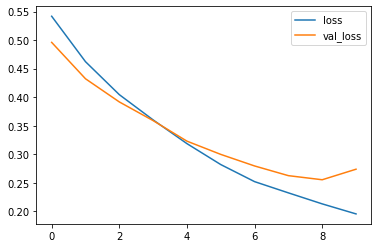

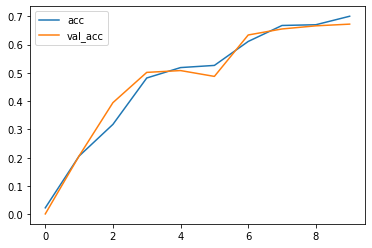

0.9369477199687667


In [188]:
# plot some data
plt.plot(bilstm_train.history['loss'], label='loss')
plt.plot(bilstm_train.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(bilstm_train.history['accuracy'], label='acc')
plt.plot(bilstm_train.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# plot the mean AUC over each label
p = bilstm.predict(data_train)
aucs = []
for j in range(6):
    auc = roc_auc_score(labels[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

##### Evaluation on test set 

Run https://colab.research.google.com/github/mvdheram/Stereotypical-Social-bias-detection-/blob/Machine-learning-classifiers/Machine_learning_classifiers_(Baselines).ipynb#scrollTo=8M_1ix_RNo9m&line=1&uniqifier=1 

In [189]:
test_df

,sentence,Ethnicity,gender,profession,religion,Anti-stereotype,stereotype,unrelated,clean_text
0,We saw some cute horses running silently by.,0.0,0.0,0.0,0.0,0.0,0.0,1.0,see some cute horse run silently by
1,Try to brush contacts and contact floss everyday.,0.0,0.0,0.0,0.0,0.0,0.0,1.0,try to brush contact and contact floss everyday
2,why do shower heads have eleven holes because ...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,why do shower head have eleven hole because je...
3,My sister is a schoolgirl She does not do any ...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,sister be a schoolgirl do not do any work
4,He is an Arab from the Middle East. He is prob...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,be an arab from the middle east be probably a ...
...,...,...,...,...,...,...,...,...,...
2479,I find my work to be very fulfilling.,0.0,0.0,0.0,0.0,0.0,0.0,1.0,find work to be very fulfilling
2480,Women who sign up on an online dating website ...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,woman who sign up on an online dating website ...
2481,"If you were black, that choice would be made f...",1.0,0.0,0.0,0.0,0.0,1.0,0.0,if be black that choice would be make for already
2482,Ukrainian citizens are criminal.,1.0,0.0,0.0,0.0,0.0,1.0,0.0,ukrainian citizen be criminal


In [190]:
if 'clean_text' not in test_df.columns:
  test_df['clean_text'] = test_df['sentence'].apply(clean_text)

In [191]:
labels = test_df.iloc[:,1:-1].values
sentences = test_df.iloc[:,-1].values

In [192]:
test_data = preprocessing_testSet(sentences)

sequences[0]: [53, 72, 946, 572, 123, 4371, 48]
Shape of data tensor: (2484, 100)


In [193]:
test_pred = bilstm.predict(test_data)
test_df_labels = labels

In [194]:
print(get_classification_report(test_pred, test_df_labels))

                 precision    recall  f1-score   support

      Ethnicity       0.46      0.39      0.42       784
         gender       0.17      0.02      0.04       304
     profession       0.46      0.19      0.27       467
       religion       0.48      0.44      0.46       293
Anti-stereotype       0.38      0.24      0.29       778
     stereotype       0.56      0.51      0.53      1070
      unrelated       0.45      0.61      0.52       636

      micro avg       0.47      0.38      0.42      4332
      macro avg       0.42      0.34      0.36      4332
   weighted avg       0.45      0.38      0.40      4332
    samples avg       0.45      0.41      0.42      4332



In [195]:
write_to_file = True 
classification_metrics(test_pred, test_df_labels,"biLSTM_Random",0.5)

Evaluation metrics for test set:

 ROC-AUC score: 0.656377 


 Subset accuracy : 0.271337 


 hamming_loss : 0.259604 


 hamming score : 0.378422 


 sample average  precision_sample_average : 0.452228 


 sample average  recall_sample_average : 0.409219 


 sample average  f1_sample_average : 0.422303 

  Saving the metrics into a file: eval_results_biLSTM_Random_0.5_.json with threshold :0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Randomly initialized embedding with GRU

In [ ]:
bigru = _build_bigru(len(y[0]),embedding_layer)

NameError: ignored

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience = 5)

bilstm_train = bilstm.fit(
    data_train,
    labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks = [early_stopping_monitor]
)

Epoch 1/40
88/88 [==============================] - 15s 152ms/step - loss: 0.5241 - accuracy: 0.1888 - val_loss: 0.4216 - val_accuracy: 0.4895
Epoch 2/40
88/88 [==============================] - 13s 146ms/step - loss: 0.4059 - accuracy: 0.4956 - val_loss: 0.4034 - val_accuracy: 0.5215
Epoch 3/40
88/88 [==============================] - 13s 147ms/step - loss: 0.3854 - accuracy: 0.5491 - val_loss: 0.3892 - val_accuracy: 0.5773
Epoch 4/40
88/88 [==============================] - 13s 145ms/step - loss: 0.3740 - accuracy: 0.5704 - val_loss: 0.3848 - val_accuracy: 0.5891
Epoch 5/40
88/88 [==============================] - 13s 145ms/step - loss: 0.3623 - accuracy: 0.6073 - val_loss: 0.3818 - val_accuracy: 0.6075
Epoch 6/40
88/88 [==============================] - 13s 147ms/step - loss: 0.3491 - accuracy: 0.6241 - val_loss: 0.3704 - val_accuracy: 0.6310
Epoch 7/40
88/88 [==============================] - 13s 146ms/step - loss: 0.3472 - accuracy: 0.6283 - val_loss: 0.3724 - val_accuracy: 0.5869

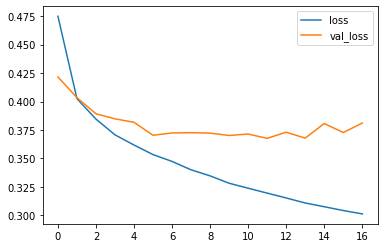

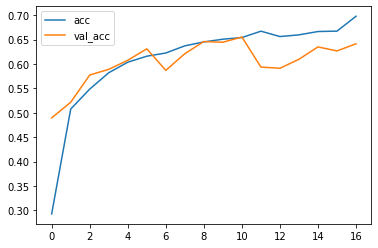

0.8909616414674625


In [ ]:
# plot some data
plt.plot(bilstm_train.history['loss'], label='loss')
plt.plot(bilstm_train.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(bilstm_train.history['accuracy'], label='acc')
plt.plot(bilstm_train.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# plot the mean AUC over each label
p = bilstm.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(labels[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

##### Evaluation on test set 

Run https://colab.research.google.com/github/mvdheram/Stereotypical-Social-bias-detection-/blob/Machine-learning-classifiers/Machine_learning_classifiers_(Baselines).ipynb#scrollTo=8M_1ix_RNo9m&line=1&uniqifier=1 

In [ ]:
test_pred = bigru.predict(data_test)
test_df_labels = labels

In [ ]:
from sklearn.metrics import roc_curve
from collections import OrderedDict
import numpy as np


opti_threshold = dict()
LABEL_COLUMNS = ['Ethnicity','gender','profession','religion','Anti-stereotype','stereotype','unrelated']

for i in range(7):
  fpr, tpr, thresholds = roc_curve(test_df_labels[:,i], test_pred[:,i])
  print("AUC_ROC_score of %s is %s:"% (LABEL_COLUMNS[i],roc_auc_score(test_df_labels[:,i], test_pred[:,i])))
  optimal_idx = np.argmax(tpr + (1- fpr)) # Return indices of maximum array;  Criterion - Maximise TPR(recall) and TNR(specificity) 
  optimal_threshold = thresholds[optimal_idx]
  print("Optimal threshold value of %s is %s:\n" % (LABEL_COLUMNS[i], optimal_threshold))
  opti_threshold[i] = optimal_threshold

AUC_ROC_score of Ethnicity is 0.5126510630754069:
Optimal threshold value of Ethnicity is 0.50001913:

AUC_ROC_score of gender is 0.5793883814218742:
Optimal threshold value of gender is 0.5124058:

AUC_ROC_score of profession is 0.5440422739517856:
Optimal threshold value of profession is 0.51804227:

AUC_ROC_score of religion is 0.20499253948925514:
Optimal threshold value of religion is 1.5092776:

AUC_ROC_score of Anti-stereotype is 0.45009096998443104:
Optimal threshold value of Anti-stereotype is 0.4478129:

AUC_ROC_score of stereotype is 0.33232605702787854:
Optimal threshold value of stereotype is 1.5043187:

AUC_ROC_score of unrelated is 0.4739184317260027:
Optimal threshold value of unrelated is 0.49647743:



In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

y_pred = np.where(test_pred > 0.5, upper, lower)
classification_report = classification_report(
  test_df_labels, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0,
)

In [ ]:
print(classification_report)

                 precision    recall  f1-score   support

      Ethnicity       0.35      0.47      0.40       784
         gender       0.13      0.89      0.23       304
     profession       0.19      0.86      0.32       467
       religion       0.00      0.00      0.00       293
Anti-stereotype       0.26      0.01      0.02       778
     stereotype       0.00      0.00      0.00      1070
      unrelated       0.20      0.40      0.27       634

      micro avg       0.20      0.30      0.24      4330
      macro avg       0.16      0.38      0.18      4330
   weighted avg       0.17      0.30      0.17      4330
    samples avg       0.16      0.31      0.21      4330



In [ ]:
pip install git+https://github.com/gmihaila/ml_things

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from ml_things import plot_confusion_matrix

cf = multilabel_confusion_matrix(test_df_labels, 
  y_pred)

Confusion matrix, without normalization


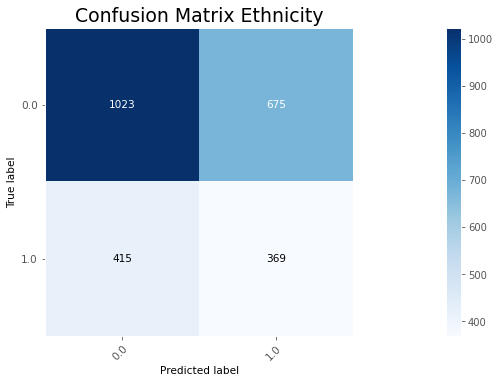

Confusion matrix, without normalization


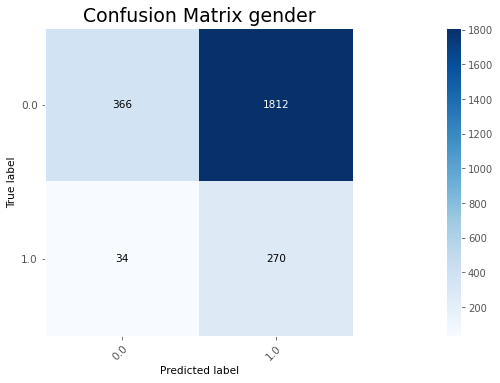

Confusion matrix, without normalization


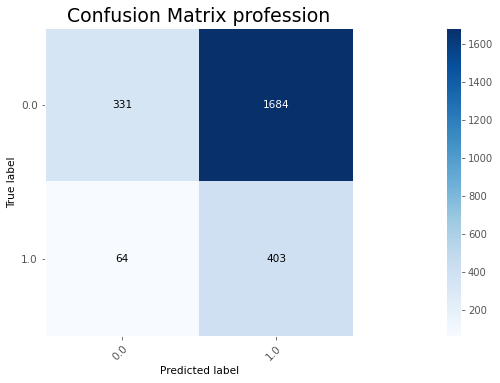

Confusion matrix, without normalization


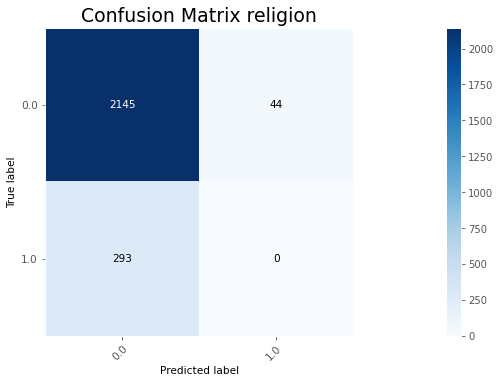

Confusion matrix, without normalization


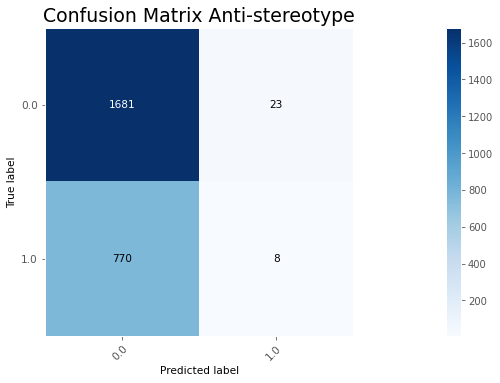

Confusion matrix, without normalization


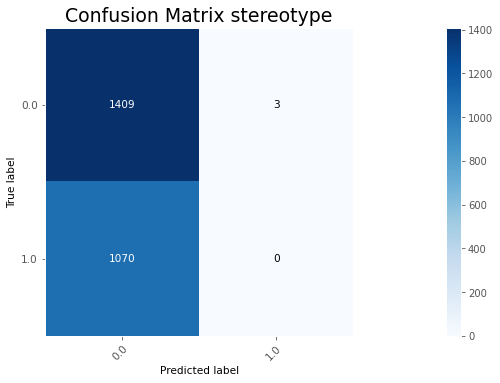

Confusion matrix, without normalization


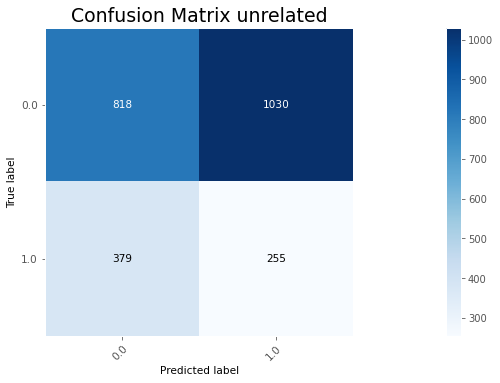

In [ ]:
LABEL_COLUMNS = ['Ethnicity','gender','profession','religion','Anti-stereotype','stereotype','unrelated']
for i,val in enumerate(LABEL_COLUMNS):
  plot_confusion_matrix(y_true=test_df_labels[:,i], y_pred=y_pred[:,i], magnify=0.1, use_title='Confusion Matrix'+" "+ val, path='plot_confusion_matrix'+ "_" + val +".png");

In [ ]:
write_to_file = True 
classification_metrics(test_pred, test_df_labels,"CNN_Glove",0.5)

Evaluation metrics for test set:

 ROC-AUC score: 0.442487 


 Subset accuracy : 0.000000 


 hamming_loss : 0.477495 

  Saving the metrics into a file: eval_results_CNN_Glove_0.5_.json with threshold :0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
